# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


Text(0, 0.5, 'total births per year')

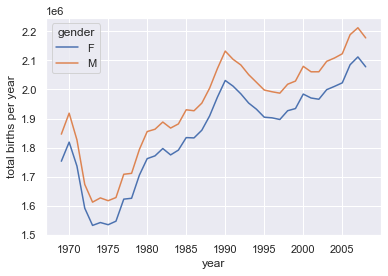

In [9]:
df = pd.read_csv('data/births.csv')
sns.set()
df[df.gender == 'F'].groupby(by='year').sum()['births'].plot(label='F')
df[df.gender == 'M'].groupby(by='year').sum()['births'].plot(label='M')
plt.legend(title='gender')
plt.ylabel('total births per year')

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

In [ ]:
# the first graph is the  number of births per day compared to the annual daily average.added to that a linear trend.
# periodic component indicates the cyclical patterns and the seasonality
# residual is the difference between the predicted value and the recorded values
# it points out outliers with less births like new year eve, christmas, independance day, labor day, thanksgiving and february 29th  
# and valentine's day with more births

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

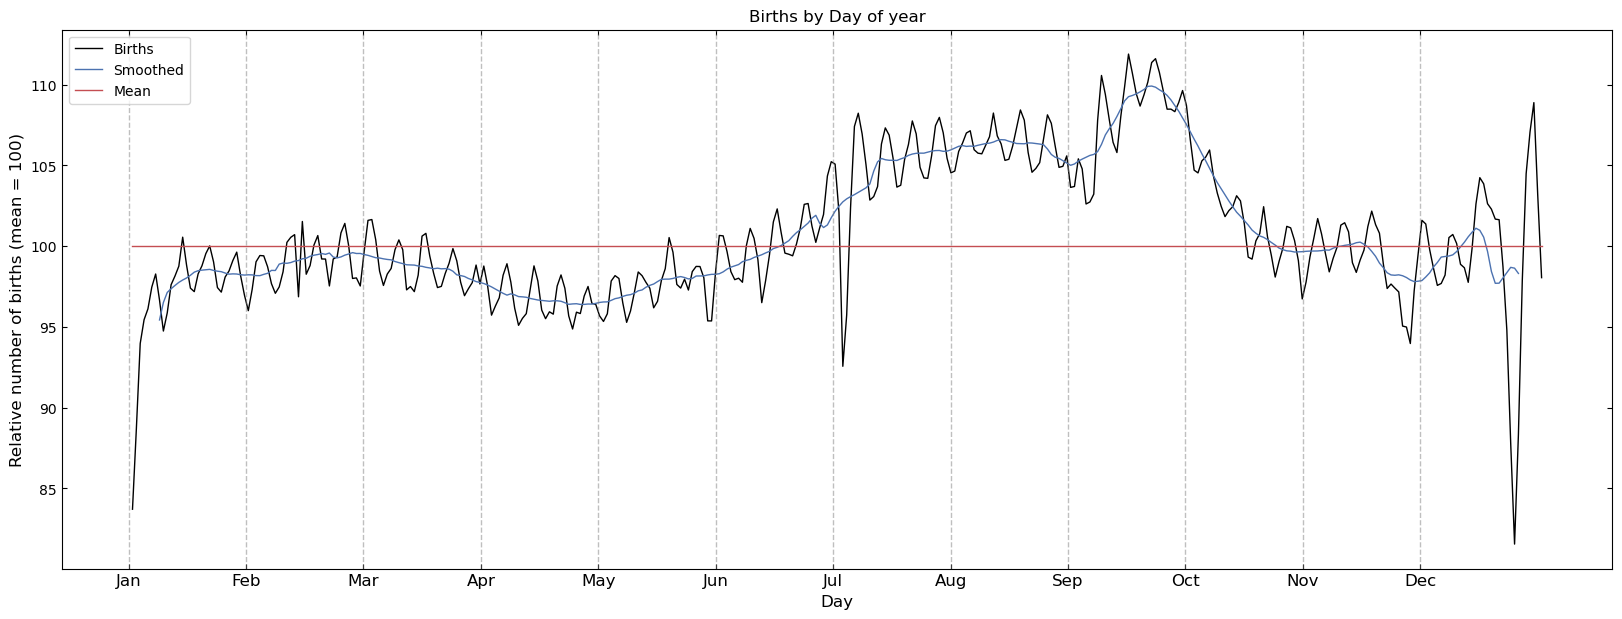

In [11]:
import datetime as dt
import numpy as np
sns.reset_orig()
df = pd.read_csv("data/births.csv")
df = df.dropna()
df = df.drop(df.index[df.day == 99.0])
df.day = df.day.astype(int)
df['date'] = pd.to_datetime(df[['year', 'month', 'day']] , errors='coerce')
df['norm'] = df.births / df.births.mean() * 100
df['avg'] = 100
df['day_of_year'] = df.date.dt.dayofyear
dt = df.groupby("day_of_year").norm.mean()
avg = df.groupby("day_of_year").avg.mean() 
rol = dt.rolling(14, center=True).mean()
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(dt, '-', linewidth=1, color='black', label='Births')
ax.plot(rol, '-', linewidth=1, color='b', label='Smoothed')
ax.plot(avg, '-', linewidth=1, color='r', label='Mean')
ax.legend()
ax.set_title('Births by Day of year')
ax.set_xlabel('Day', size=12)
ax.set_ylabel('Relative number of births (mean = 100)', size=12)
ax.tick_params(direction = 'in', top = True, right = True)
plt.xticks(np.linspace(0,365,13)[:-1], ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'), size=12)
for tick in plt.xticks()[0]:
    plt.axvline(tick, color='gray', linestyle='--', linewidth=1, alpha=.5)
plt.show()

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [28]:
import gzip
# read the entire file into a Python array
with gzip.open('data/recipe.json.gz', 'r') as f:
    # Extract each line
    data = (line.strip().decode() for line in f)
    # Reformat so each line is the element of a list
    data_json = f"[{','.join(data)}]"
# read the result as a JSON
recipes = pd.read_json(data_json)

In [29]:
recipes.description.str.lower().str.contains("breakfast").sum() # 3524

3524

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [30]:
recipes['ingredients'].isin(['Biscuits'])
recipes['ingredients'].str.contains('flour', regex=False, case=False)

def recommend_ingredients(ing_lst, df):
    """
    Finds the index of recipes
    which contain all ingredients
    in ing_lst.
    """

    res = df.ingredients.apply(lambda sentence: all(word in sentence for word in ing_lst))
    return df[res].index

In [31]:
recommend_ingredients(["parsley", "paprika", "tarragon"], recipes)

Int64Index([2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175,
            165243],
           dtype='int64')

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [32]:
import pandas as pd
import numpy as np
import json
import re
credits = pd.read_csv('data/credits.csv')

FileNotFoundError: [Errno 2] File data/credits.csv does not exist: 'data/credits.csv'

In [33]:
def unpack_row(r):
    """
    This function is an 
    accumulation of regex and 
    string manipulations to
    get a json-compatible format
    for each row in the DataFrame.

    It caters mostly for the variations
    of names like "O'Conner" and 
    'Charles "Chuck" Shulz' both of 
    which cause errors when reading.
    """
    r = re.sub(r"(?<=[A-Za-zÀ-ÿ])'(?=[A-Za-zÀ-ÿ])", " ", r)  # fixes O'Conner and variants
    r = re.sub(r"(?<=[A-Za-z.]\s)'(?=[A-Za-z])", " ", r) # fixes first part of nickname Reggie "J.R" Jackson
    r = re.sub(r"(?<=[A-Za-z.])'(?=\s[A-Za-z])", " ", r) # fixes last part of nickname
    r = re.sub(r"(?<=:\s)\"'(?=[A-Za-z])", '"', r) # fixes "'Chema' Hernandez" first single quote
    r = r.replace('\'",', '",') # fixes "Randy 'Fife'" ending quotes
    r = r.replace(': "', ": '") # fixes "Janice O'Conner" start double quotes
    r = r.replace('" :', "' :") # fixes double quotes on O' names end
    r = r.replace('",', "',") # fixes double quotes on O' names end
    r = r.replace('"}', "'}") # fixes double quotes at end of set
    r = r.replace('"', ' ') # eliminates any remaining double quotes
    r = r.replace("'", '"') # convert all single to double quotes
    r = r.replace('None,','"None"')
    r = r.replace('None}','"None"}')
    r = json.loads(r,strict=False)
    for d in r:
        if d['job'] == 'Director':
            return d['name']
    return 'NaN'

# call the string cleaner
res = credits.crew.apply(unpack_row)

# build the dataframe
directors = pd.DataFrame(np.array(res), index = credits.id, columns=['directors'])
directors

AttributeError: '_Printer' object has no attribute 'crew'

In [35]:
ratings_ovr_N = ratings.where(ratings.groupby(by='movieId').count()['userId'] >= N).dropna(axis=0)
ratings_ovr_N

NameError: name 'ratings' is not defined